# **Translating Spanish to English:**

In this repository we are going to translate spanish to english.This code works for other languages too.

The data comes from- http://www.manythings.org/anki/


In [1]:
#Getting the data

!wget http://www.manythings.org/anki/spa-eng.zip

--2020-01-25 19:55:40--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767708 (4.5M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   4.55M  15.2MB/s    in 0.3s    

2020-01-25 19:55:40 (15.2 MB/s) - ‘spa-eng.zip’ saved [4767708/4767708]



In [2]:
# Importing the required libraries

import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model,Model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [3]:
# Unzipping the folder

!unzip spa-eng.zip

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 


In [0]:
#Opening text file

file=open("spa.txt",mode="rt",encoding="utf-8") #rt=read as text
data=file.read()  #complete data is read and saved from file

In [0]:
def to_lines(text):
  sent=text.strip().split("\n")   #strip removes unncessary spaces , now each sentence is splitted in new line
  sent=[r.split("\t") for r in sent] #splitted on basis of tab
  return sent

In [6]:
# We will just use 0 and 1st index as the 0th index is text in english and 1st index is text in spanish
spa_eng=to_lines(data)
spa_eng=np.array(spa_eng)
spa_eng[100]    

array(['Try it.', 'Pruébalo.',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #4756252 (cairnhead) & #4748670 (ecorralest101)'],
      dtype='<U332')

In [0]:
# Taking top 100 k translation sentences out of 20 lakh sentences

spa_eng=spa_eng[:100000,:2] # 100k rows and first two columns

#**Preprocessing**

We will use following functions:

maketrans()- translational table->character to replace, character that replace, character to delete

string.punctiations() -set of all punctuation marks

translate function is applied on strings along with maketrans() which passes tarnalstional table

In [0]:
import string
#english senetences, all rows but 0th col

spa_eng[:,0]=[s.translate(s.maketrans('','',string.punctuation)).lower() for s in spa_eng[:,0] ]

#spanish sentences
spa_eng[:,1]=[s.translate(s.maketrans('','',string.punctuation)).lower() for s in spa_eng[:,1] ]

# convert text to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    spa_eng[i,1] = spa_eng[i,1].lower()


# spa_eng[:10,:]

#**Tokenization**

For processing the text and using the RNNs layers such as LSTMs we need to tokenize the input before that is converting the string to integer sequence of fixed length.



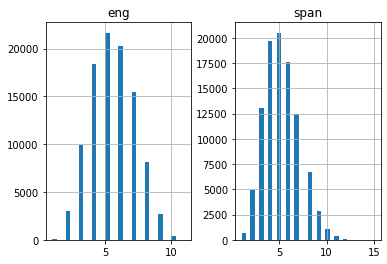

In [9]:
eng=[]
span=[]
for i in (spa_eng[:,0]):
  eng.append(len(i.split()))
for i in (spa_eng[:,1]):
  span.append(len(i.split()))
length_df = pd.DataFrame({'eng':eng,'span':span})

length_df.hist(bins = 30)
plt.show()
eng_length,span_length=max(eng),max(span)


In [0]:
# tokenizing all the words (split words from senetences to get individual words)

def tokenization(line):
  tokenizer=Tokenizer() # words will be split and dictionary will be crated
  tokenizer.fit_on_texts(line)
  return tokenizer  # returns dict

In [11]:
# call tokenization spearately on english and spanish so that words dont mix

eng_tokenizer=tokenization(spa_eng[:,0])

spa_tokenizer=tokenization(spa_eng[:,1])

#no of words 
eng_vocab_size=len(eng_tokenizer.word_index)+1
spa_vocab_size=len(spa_tokenizer.word_index)+1
print(eng_vocab_size)  #due to padding=0 we are using +1 , so our size is 1 extra due to this

print(spa_vocab_size)
print(eng_tokenizer.word_index)

11040
22372
{'i': 1, 'to': 2, 'you': 3, 'the': 4, 'tom': 5, 'a': 6, 'is': 7, 'he': 8, 'in': 9, 'do': 10, 'it': 11, 'me': 12, 'this': 13, 'that': 14, 'my': 15, 'was': 16, 'of': 17, 'have': 18, 'dont': 19, 'she': 20, 'are': 21, 'for': 22, 'what': 23, 'im': 24, 'your': 25, 'we': 26, 'want': 27, 'mary': 28, 'his': 29, 'on': 30, 'be': 31, 'know': 32, 'like': 33, 'not': 34, 'with': 35, 'at': 36, 'can': 37, 'go': 38, 'him': 39, 'has': 40, 'did': 41, 'very': 42, 'they': 43, 'its': 44, 'here': 45, 'her': 46, 'how': 47, 'there': 48, 'and': 49, 'were': 50, 'all': 51, 'will': 52, 'didnt': 53, 'up': 54, 'cant': 55, 'time': 56, 'about': 57, 'think': 58, 'get': 59, 'as': 60, 'had': 61, 'youre': 62, 'why': 63, 'please': 64, 'no': 65, 'ill': 66, 'an': 67, 'come': 68, 'out': 69, 'good': 70, 'need': 71, 'see': 72, 'going': 73, 'one': 74, 'doesnt': 75, 'now': 76, 'from': 77, 'just': 78, 'by': 79, 'help': 80, 'where': 81, 'who': 82, 'am': 83, 'got': 84, 'ive': 85, 'never': 86, 'us': 87, 'tell': 88, 'too': 

In [0]:
#length is max length allowed, lines are the data to be encoded

def encode_sequences(tokenizer,length,lines):
  seq=tokenizer.texts_to_sequences(lines)   #stores the codes in seq

  seq=pad_sequences(seq,maxlen=length,padding="post")
  return seq

In [0]:
from sklearn.model_selection import train_test_split
train,test=train_test_split(spa_eng,test_size=0.33,random_state=0)

# preparing training data
trainX = encode_sequences(spa_tokenizer, 8, train[:, 1])
trainY = encode_sequences(eng_tokenizer, 8, train[:, 0])

# prepare testing data
testX = encode_sequences(spa_tokenizer, 8, test[:, 1])
testY = encode_sequences(eng_tokenizer, 8, test[:, 0])


In [14]:
print(trainX.shape)
print(trainX[0])

print(trainY.shape)
print(trainY[0])

(67000, 8)
[  2  54 328  30   0   0   0   0]
(67000, 8)
[  1  55 286 137 101   0   0   0]


In [15]:
from keras.layers import Dense,LSTM,Embedding,RepeatVector
from keras.models import Sequential
from keras import optimizers
import warnings
warnings.filterwarnings("ignore")
model=Sequential()
model.add(Embedding(spa_vocab_size,512,input_length=8))
model.add(LSTM(512))  #output of LSTM is thought vector , this is encoder
model.add(RepeatVector(8))
model.add(LSTM(512,return_sequences=True))
model.add(Dense(eng_vocab_size,activation='softmax')) # we will get word with max prob out of all the words in eng vocab
model.compile(optimizer=optimizers.RMSprop(lr=0.001),loss="sparse_categorical_crossentropy") #sparse_CCE ouputs labels instead of one hot encoded, we dont have to use argmax now

In [16]:
# to save the best model

from keras.callbacks import ModelCheckpoint
#save according to metric value loss and mode =min means save the min loss

checkpoint=ModelCheckpoint("model.h1",monitor="val_loss",verbose=1,save_best_only=True,mode="min")

history=model.fit(trainX,
                  trainY.reshape(trainX.shape[0],trainY.shape[1],1),
                  epochs=30,
                  batch_size=512,
                  validation_split=0.33,
                  callbacks=[checkpoint],
                  verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 44889 samples, validate on 22111 samples
Epoch 1/30





44889/44889 [==============================] - 20s 448us/step - loss: 4.7380 - val_loss: 4.4306

Epoch 00001: val_loss improved from inf to 4.43058, saving model to model.h1
Epoch 2/30
44889/44889 [==============================] - 9s 209us/step - loss: 4.2641 - val_loss: 4.1886

Epoch 00002: val_loss improved from 4.43058 to 4.18856, saving model to model.h1
Epoch 3/30
44889/44889 [==============================] - 10s 213us/step - loss: 4.0140 - val_loss: 3.9920

Epoch 00003: val_loss improved from 4.18856 to 3.99197, saving model to model.h1
Epoch 4/30
44889/44889 [==============================] - 9s 210us/step - loss: 3.8466 - val_loss: 3.8554

Epoch 00004: val_loss improved from 3.99197 to 3.85537, saving model to model.h1
Epoch 5/30
44889/44889 [==============================] - 9s 209us/step - loss: 3.6459 - val_loss:

In [0]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
#loading best saved model
model=load_model("model.h1")


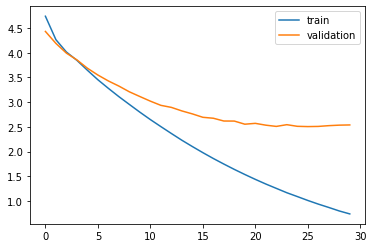

In [18]:
#plotting the loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
#the predictions are encoded sequences and we need to convert them into words 
preds=model.predict_classes(testX)
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None


preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'spanish':test[:,1],'actual' : test[:,0], 'predicted' : preds_text})

In [21]:
pred_df

,spanish,actual,predicted
0,han salido,theyve left,theres has
1,enséñame cómo se hace por favor,show me how to do it please,please me how it this
2,¿por qué no me paró alguien,why didnt someone stop me,why didnt tom stop me
3,no se lo diré a nadie,i wont tell anyone,i wont tell anyone
4,tenés que comer,you must eat,you have to eat
...,...,...,...
32995,¿de verdad quieres hablar de esto ahora,do you really wanna talk about this now,do really to do this
32996,tu amiga está aquí,your friend is here,your shirt is good
32997,no sabía que tom tenía un hermano,i didnt know tom had a brother,i didnt know tom was a canadian
32998,¿sabéis bailar,do you know how to dance,do you dance how to


So, the results generated are not perfect and there is room for improvement.Including more data and using data augmentation can improve the results.Further, layers can be increased.